In [1]:
# Install needed stuff to the Jupyter and kernel environment
# Need to install only once, so commented out for cleaner output
# %pip install pyarrow
# %pip install pandas
# %pip install numpy
# %pip install matplotlib
# %pip install pyfinance
# %pip install yfinance
# %pip install yahoo-fin

In [2]:
# Import needed stuff
import sys
import pyarrow.feather as feather
import math
import pandas
import numpy as np
import matplotlib.pyplot as plt
from pyfinance.options import BSM
import yfinance as yf
from datetime import datetime, timedelta, date
from yahoo_fin import options as op

In [3]:
# General Delta-hedging function
def number_of_shares_to_buy(shares_per_contract, number_of_options, delta_of_option):
    delta_of_underlying = 1 # why?

    # Delta-hedging says:
    # number_of_shares * delta_of_underlying + number_of_options * delta_of_option = 0
    number_of_shares = (-number_of_options * delta_of_option / delta_of_underlying ) * shares_per_contract

    print("To delta-hedge the portoflio, you need to",("buy" if number_of_shares >= 0 else "sell"), round(np.abs(number_of_shares),2), "shares.")
    return number_of_shares


In [4]:
# General volatility function
def get_volatility(stock_data):
    log_returns = np.log(stock_data/stock_data.shift(1)).dropna()
    volatility = log_returns.rolling(window = 21).std() * np.sqrt(252)
    return volatility
    

In [5]:
# General plot function
def plot_stock_price_and_volatility(stock_prices, volatility):
    fig, ax = plt.subplots()
    ax.plot(stock_prices, color='red')
    ax.set_xlabel('Date', fontsize = 14)
    ax.set_ylabel('Underlying price', color='red', fontsize = 14)
    
    ax2 = ax.twinx()
    ax2.plot(volatility, color = 'blue')
    ax2.set_ylabel('Volatility', color = 'blue', fontsize = 14)
    
    plt.show()
    

## Let's use Apple stock data from Refinitiv here

Delta of the call option: 0.56291693680677
Delta of the put option: -0.43708306319323
To delta-hedge the portoflio, you need to sell 56.29 shares.
To delta-hedge the portoflio, you need to buy 43.71 shares.


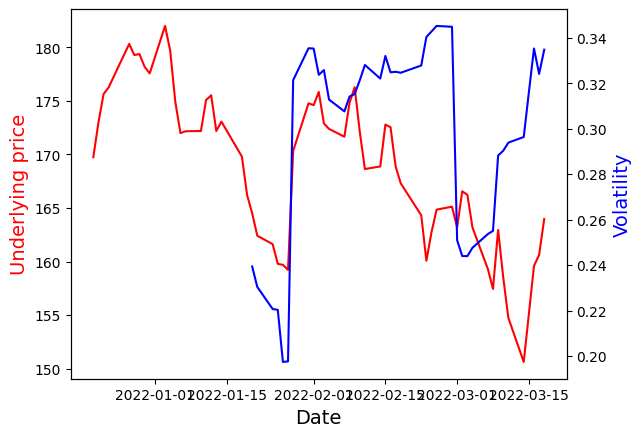

In [6]:
# Read data and show it, data is from Refinitiv workspace
apple_stock_data_as_df = feather.read_feather('../data/fe2.feather')

# Set date to index instead of running index from 1..n
date_as_index = apple_stock_data_as_df.set_index('Date', inplace=False)

vola = get_volatility(date_as_index['Underlying'])

# Set values
shares_per_contract = 100 # How this is determined ?

number_of_options = 1 # How this is determined? 1 stock = 1 option, n stocks = n options?

# Use Black-Scholes model to compute the delta of the call option
# T = maturity and r = interest rate just thrown there, no spesific reason I guess to be those
call_delta = BSM(kind='call', S0=date_as_index['Underlying'].iloc[-1], K=date_as_index['Underlying'].iloc[-1], T=0.25, r=0.05, sigma=vola.iloc[-1]).delta()

# Delta of the call option is always positive and between 0 and 1
print("Delta of the call option:", call_delta)

# Use Black-Scholes model to compute the delta of the put option
# Again T = maturity and r = interest rate are just thrown there, no spesific reason to be those (I think)
put_delta = BSM(kind='put', S0=date_as_index['Underlying'].iloc[-1], K=date_as_index['Underlying'].iloc[-1], T=0.25, r=0.05, sigma=vola.iloc[-1]).delta()

# Delta of the put option is always negative and between 0 and -1
print("Delta of the put option:", put_delta)

# Get the amounts to balance, aka delta-hedge the portfolio
how_many_shares_to_sell = number_of_shares_to_buy(shares_per_contract, number_of_options, call_delta)

how_many_shares_to_buy = number_of_shares_to_buy(shares_per_contract, number_of_options, put_delta)

plot_stock_price_and_volatility(date_as_index['Underlying'], vola)

# Lets try with S&P 500 data

[*********************100%%**********************]  1 of 1 completed


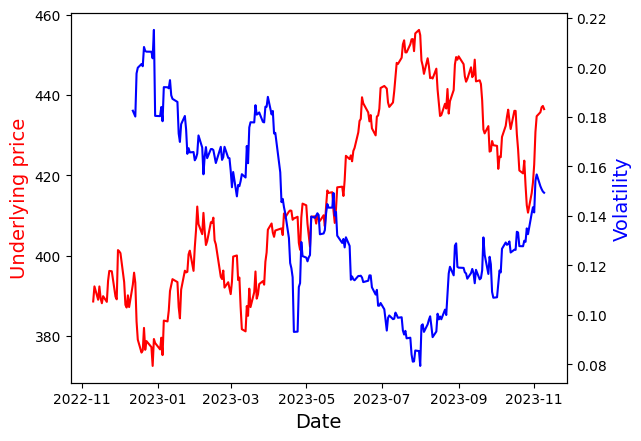

Delta of the call option: 0.5811159098623541
Delta of the put option: -0.41888409013764594
To delta-hedge the portoflio, you need to sell 58.11 shares.
To delta-hedge the portoflio, you need to buy 41.89 shares.


In [7]:
stock_name = 'SPY'
years = 1
stock_data = yf.download(tickers = stock_name, start = datetime.today() - timedelta(days=years*365), end = datetime.today())

stock_data # Date as index, Open, High, Low, Close, Adj Close, Volume

stock_prices = stock_data['Adj Close'] # Closing prices
spy_vola = get_volatility(stock_prices)
plot_stock_price_and_volatility(stock_prices, spy_vola)

# Set values
shares_per_contract = 100 # How this is determined ?

number_of_options = 1 # How this is determined? 1 stock = 1 option, n stocks = n options?

# Use Black-Scholes model to compute the delta of the call option
# T = maturity and r = interest rate just thrown there, no spesific reason I guess to be those
call_delta = BSM(kind='call', S0=stock_prices.iloc[-1], K=stock_prices.iloc[-1], T=0.25, r=0.05, sigma=spy_vola.iloc[-1]).delta()

# Delta of the call option is always positive and between 0 and 1
print("Delta of the call option:", call_delta)

# Use Black-Scholes model to compute the delta of the put option
# Again T = maturity and r = interest rate are just thrown there, no spesific reason to be those (I think)
put_delta = BSM(kind='put', S0=stock_prices.iloc[-1], K=stock_prices.iloc[-1], T=0.25, r=0.05, sigma=spy_vola.iloc[-1]).delta()

# Delta of the put option is always negative and between 0 and -1
print("Delta of the put option:", put_delta)

# Get the amounts to balance, aka delta-hedge the portfolio
how_many_shares_to_sell = number_of_shares_to_buy(shares_per_contract, number_of_options, call_delta)

how_many_shares_to_buy = number_of_shares_to_buy(shares_per_contract, number_of_options, put_delta)

# Hedging assigment

# Fetch real option data using Yahoo_fin

### This approach is work in progress for now

In [12]:
# Another viable dataset
def fetch_sp500_yahoofin():
    ticker = 'SPY'
    expiration_dates = op.get_expiration_dates(ticker)
    exp = pandas.DataFrame(expiration_dates)
    # print(exp)
    calls = op.get_calls(ticker, date = expiration_dates[13]) # Chose 29.12.2023 
    c = pandas.DataFrame(calls)
    print(c)
    
    long_position_in_call = c.iloc[0]
    print(long_position_in_call)
    print(long_position_in_call['Strike'])
    
    #puts = op.get_puts(ticker, date = expiration_dates[14])
    #print(puts)
    #chain_data = op.get_options_chain(ticker, date=expiration_dates[14])
    #print(chain_data)

# Fetch using yfinance

### Data fetching and wrangling

In [13]:
# Get sp500 index data from Yahoo Finance
sp500 = yf.Ticker('^SPX')

# Get expiration dates of the options to a dataframe
expiration_dates = pandas.DataFrame(data=sp500.options)

# Debug print
print(expiration_dates)

# Write expiration dates to a .csv file to same directory
expiration_dates.to_csv('sp500_expiration_dates.csv', sep='\t', index=False)

# Get expiration date, which is around 45 days to maturity from this day, in this case 29.12.2023
expiration = expiration_dates.iloc[27][0]

# Get the option chain for the sp500 data
option_chain_for_expiration = sp500.option_chain(expiration) # expiration 29.12.2023

# We will use call options for the hedging assignment, construct them to a dataframe
opt_calls = pandas.DataFrame(option_chain_for_expiration.calls)

# Write call options for the certain expiration date to a .csv file in the same directory
opt_calls.to_csv('sp500_calls.csv', sep='\t', index=False)

# Debug print
print(opt_calls)

# Get also the Put options and construct them to a dataframe and write to a .csv file in the same directory
# Optional and not needed yet in the assignment
opt_puts = pandas.DataFrame(option_chain_for_expiration.puts)
opt_puts.to_csv('sp500_puts.csv', sep='\t', index=False)

             0
0   2023-11-09
1   2023-11-10
2   2023-11-13
3   2023-11-14
4   2023-11-15
5   2023-11-16
6   2023-11-17
7   2023-11-20
8   2023-11-21
9   2023-11-22
10  2023-11-24
11  2023-11-27
12  2023-11-28
13  2023-11-29
14  2023-11-30
15  2023-12-01
16  2023-12-04
17  2023-12-05
18  2023-12-06
19  2023-12-07
20  2023-12-08
21  2023-12-11
22  2023-12-12
23  2023-12-14
24  2023-12-15
25  2023-12-22
26  2023-12-29
27  2024-01-19
28  2024-01-31
29  2024-02-16
30  2024-02-29
31  2024-03-15
32  2024-03-28
33  2024-04-19
34  2024-04-30
35  2024-05-17
36  2024-06-21
37  2024-06-28
38  2024-07-19
39  2024-08-16
40  2024-09-20
41  2024-09-30
42  2024-10-18
43  2024-11-15
44  2024-12-20
45  2025-01-17
46  2025-06-20
47  2025-12-19
48  2026-03-20
49  2026-12-18
50  2027-12-17
51  2028-12-15
          contractSymbol             lastTradeDate  strike  lastPrice     bid  \
0    SPXW240119C00200000 2023-11-08 20:24:34+00:00   200.0    4169.70  4155.2   
1    SPXW240119C00400000 2023-11-06 19:51:2

In [16]:
# Get the days to maturity
days_to_maturity = datetime(2023, 12, 29) - datetime.today()

# Get time to maturity in years
t = int(days_to_maturity.days)/365

# Debug print
print(t)
print("Days to maturity in days is", days_to_maturity.days) # 49 days_to_maturity

# time at t = 0, the date when the date waspulled
t0 = datetime(2023, 11, 9).date()
print("Time at t = 0 aka today", t0)

# call option with price C0 at time t0
c0 = opt_calls['lastPrice'].iloc[0]
print('Price of Call option c0 in time t0', c0)

# US treasury 10-year bond yield?
r = 0.05

# What would be a good value? 0.2 is used in the exercies
sigma = 0.2

# Value of the BSM for the call option c0 at time t0
val = BSM(kind='call', S0=c0, K=opt_calls['strike'].iloc[0], T=t, r=r, sigma=sigma).value() 
print('value from BSM', val)

# Delta of the BSM for the call option c0 at time t0
delta = BSM(kind='call', S0=c0, K=opt_calls['strike'].iloc[0], T=t, r=r, sigma=sigma).delta()
print('Delta from BSM', delta)

number_of_shares_to_buy(100,1,delta)

# TODO:

# Construct two portfolios
# op = long position in one call, op0 = c0
# re = short position containing delta amount of the underlying asset S, re0 = delta0 * s0 (stock price at 0)
# Changes in the protfolio OP are neutralized by oppsite changes in the replicatin portfolio re
# rehedge every second day
# Compute how much every portfolio has changed
# Count mean squared error

0.13424657534246576
Days to maturity in days is 49
Time at t = 0 aka today 2023-11-09
Price of Call option c0 in time t0 4169.7
value from BSM 3971.0379702816617
Delta from BSM 1.0
To delta-hedge the portoflio, you need to sell 100.0 shares.


-100.0